# EJERCICIO DE MODELO KMEANS
### FUENTE: [KAGGLE - MALL CUSTOMER](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")
file = '/Mall_Customers.csv'


path_file = path + file

print("Path to dataset files:", path_file)

df = pd.read_csv(path_file,header=None)
df.head(5)

Path to dataset files: /kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


,0,1,2,3,4
0,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
1,1,Male,19,15,39
2,2,Male,21,15,81
3,3,Female,20,16,6
4,4,Female,23,16,77


# EDA

In [5]:
df.dtypes

,0
0,object
1,object
2,object
3,object
4,object


## VERIFICAMOS NULOS Y DUPLICADOS

In [13]:
df.isnull().sum().sum()

np.int64(0)

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df.shape

(201, 5)

## CODIFICAMOS VARIABLES CATEGORICAS

In [18]:
column_names = ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df = pd.read_csv(path_file, header=None, names=column_names)

In [19]:
df2 = df.copy()

In [10]:
!pip install category-encoders
import category_encoders as ce

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.6 MB/s eta 0:00:00


In [20]:
encoder_ordinal = ce.OrdinalEncoder(cols=['Gender'])
df2 = encoder_ordinal.fit_transform(df2)
df2.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,CustomerID,1,Age,Annual Income (k$),Spending Score (1-100)
1,1,2,19,15,39
2,2,2,21,15,81
3,3,3,20,16,6
4,4,3,23,16,77


## VERIFICACIÓN DE OUTLIERS

In [27]:
for col in numeric_cols:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')


In [28]:
from scipy.stats import zscore

# Seleccionar solo las columnas numéricas (excluyendo CustomerID si no es relevante)
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
z_scores = df2[numeric_cols].apply(zscore)

# Identificar valores fuera de ±3 desviaciones estándar
outliers = (z_scores.abs() > 3)

# Contar cuántos outliers hay por variable
print(outliers.sum())

# Filtrar solo las filas que contienen al menos un outlier
df_outliers = df2[outliers.any(axis=1)]
df_outliers.head()




Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)


# ELIMINACIÓN DE COLUMNAS INNECESARIAS

In [29]:
df2.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [30]:
df2.drop(['CustomerID'], axis=1, inplace=True)
df2.head(5)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,NaN,NaN,NaN
1,2,19.0,15.0,39.0
2,2,21.0,15.0,81.0
3,3,20.0,16.0,6.0
4,3,23.0,16.0,77.0


# ESCALAMIENTO DE DATOS

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)
df_scaled.head(5)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0.0,NaN,NaN,NaN
1,0.5,0.019231,0.000000,0.387755
2,0.5,0.057692,0.000000,0.816327
3,1.0,0.038462,0.008197,0.051020
4,1.0,0.096154,0.008197,0.775510


In [33]:
df_scaled.rename(columns={'Gender':'genero','Age':'edad','Annual Income (k$)':'ingreso','Spending Score (1-100)':'puntaje'},inplace=True)
df_scaled.head()

,genero,edad,ingreso,puntaje
0,0.0,NaN,NaN,NaN
1,0.5,0.019231,0.000000,0.387755
2,0.5,0.057692,0.000000,0.816327
3,1.0,0.038462,0.008197,0.051020
4,1.0,0.096154,0.008197,0.775510


In [36]:
df_scaled_cleaned = df_scaled.dropna().reset_index(drop=True)


In [37]:
print("Total de nulos después de limpiar:", df_scaled_cleaned.isnull().sum().sum())


Total de nulos después de limpiar: 0


# APLICACIÓN DEL MODELO KMEANS

## BÚSQUEDA DEL NÚMERO ÓPTIMO DE CLUSTERS (MÉTODO DEL CODO)

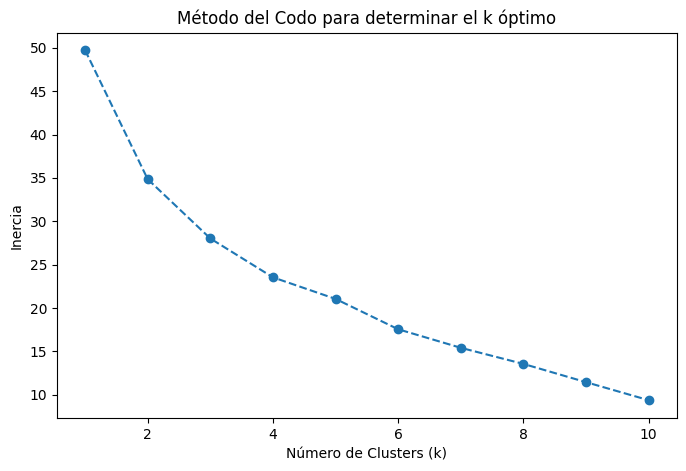

In [40]:
from sklearn.cluster import KMeans

inertia = []
k_values = range(1,11)

for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(df_scaled_cleaned)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar el k óptimo')
plt.show()

## SE UTILIZARÁ UN K ÓPTIMO DE 2

In [41]:
from sklearn.metrics import silhouette_score

In [44]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(df_scaled_cleaned)
labels = kmeans.labels_
X_scaled = df_scaled_cleaned.to_numpy()
silhouette_value = silhouette_score(X_scaled, labels)
print(f'Coeficiente de Silueta para k={k} : {silhouette_value}')

Coeficiente de Silueta para k=2 : 0.27738516765953786


## APLICACIÓN DE DISTINTOS PARÁMETROS PARA OPTIMIZAR EL MODELO

In [48]:
import itertools
# Valores a probar
def best_kmeans_params(X):
  X_scaled = X
  n_clusters_options = range(2, 20)
  init_options = ['k-means++', 'random']
  max_iter_options = [300, 500]
  tol_options = [1e-4, 1e-5, 1e-3]
  n_init_options = [10, 15]
  algorithm_options = ['lloyd', 'elkan']

  # Todas las combinaciones posibles de parámetros
  param_combinations = list(itertools.product(n_clusters_options, init_options, max_iter_options, tol_options, n_init_options, algorithm_options))

  best_silhouette = -1
  best_params = None
  silhouette_scores = {}

  # Probar todas las combinaciones
  for n_clusters, init, max_iter, tol, n_init, algorithm in param_combinations:
      try:
          kmeans = KMeans(
              n_clusters=n_clusters,
              init=init,
              max_iter=max_iter,
              tol=tol,
              n_init=n_init,
              algorithm=algorithm,
              random_state=42
          )
          kmeans.fit(X_scaled)
          labels = kmeans.labels_
          silhouette = silhouette_score(X_scaled, labels)

          if n_clusters not in silhouette_scores:
              silhouette_scores[n_clusters] = []
          silhouette_scores[n_clusters].append(silhouette)

          print(f'n_clusters={n_clusters}, init={init}, max_iter={max_iter}, tol={tol}, n_init={n_init}, algorithm={algorithm} -> Silhouette: {silhouette:.4f}')

          if silhouette > best_silhouette:
              best_silhouette = silhouette
              best_params = (n_clusters, init, max_iter, tol, n_init, algorithm)
      except Exception as e:
          print(f'Error con parámetros n_clusters={n_clusters}, init={init}, max_iter={max_iter}, tol={tol}, n_init={n_init}, algorithm={algorithm}: {e}')

  # Mostrar mejor combinación
  print("\nMejores parámetros encontrados:")
  print(f'n_clusters={best_params[0]}, init={best_params[1]}, max_iter={best_params[2]}, tol={best_params[3]}, n_init={best_params[4]}, algorithm={best_params[5]} -> Mejor Silhouette: {best_silhouette:.4f}')

  # Graficar coeficiente de silueta
  avg_silhouette_scores = {k: np.mean(v) for k, v in silhouette_scores.items()}
  n_clusters_list = sorted(avg_silhouette_scores.keys())
  silhouette_values = [avg_silhouette_scores[k] for k in n_clusters_list]

  plt.figure(figsize=(8, 5))
  plt.plot(n_clusters_list, silhouette_values, marker='o', linestyle='-', color='b')
  plt.xlabel('Número de Clusters')
  plt.ylabel('Coeficiente de Silueta Promedio')
  plt.title('Coeficiente de Silueta para distintos valores de K')
  plt.grid()
  plt.show()

n_clusters=2, init=k-means++, max_iter=300, tol=0.0001, n_init=10, algorithm=lloyd -> Silhouette: 0.2774
n_clusters=2, init=k-means++, max_iter=300, tol=0.0001, n_init=10, algorithm=elkan -> Silhouette: 0.2774
n_clusters=2, init=k-means++, max_iter=300, tol=0.0001, n_init=15, algorithm=lloyd -> Silhouette: 0.2774
n_clusters=2, init=k-means++, max_iter=300, tol=0.0001, n_init=15, algorithm=elkan -> Silhouette: 0.2774
n_clusters=2, init=k-means++, max_iter=300, tol=1e-05, n_init=10, algorithm=lloyd -> Silhouette: 0.2774
n_clusters=2, init=k-means++, max_iter=300, tol=1e-05, n_init=10, algorithm=elkan -> Silhouette: 0.2774
n_clusters=2, init=k-means++, max_iter=300, tol=1e-05, n_init=15, algorithm=lloyd -> Silhouette: 0.2774
n_clusters=2, init=k-means++, max_iter=300, tol=1e-05, n_init=15, algorithm=elkan -> Silhouette: 0.2774
n_clusters=2, init=k-means++, max_iter=300, tol=0.001, n_init=10, algorithm=lloyd -> Silhouette: 0.2774
n_clusters=2, init=k-means++, max_iter=300, tol=0.001, n_ini

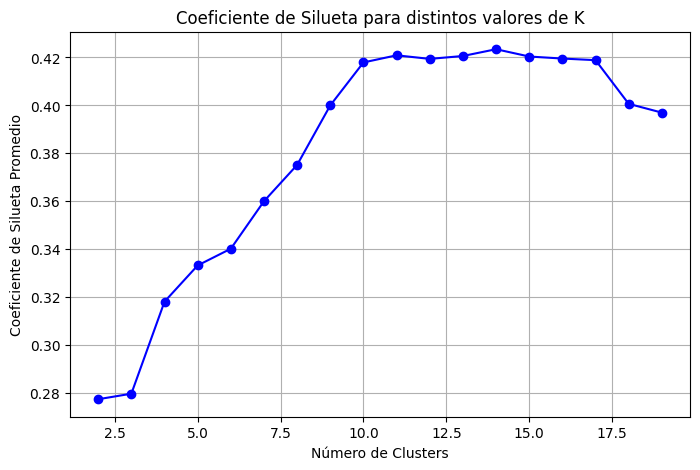

In [50]:
X = df_scaled_cleaned.to_numpy()
best_kmeans_params(X)

In [51]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, tol=0.0001, n_init=10, algorithm='lloyd', random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
silhouette = silhouette_score(X, labels)
silhouette

np.float64(0.27738516765953786)

## ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)

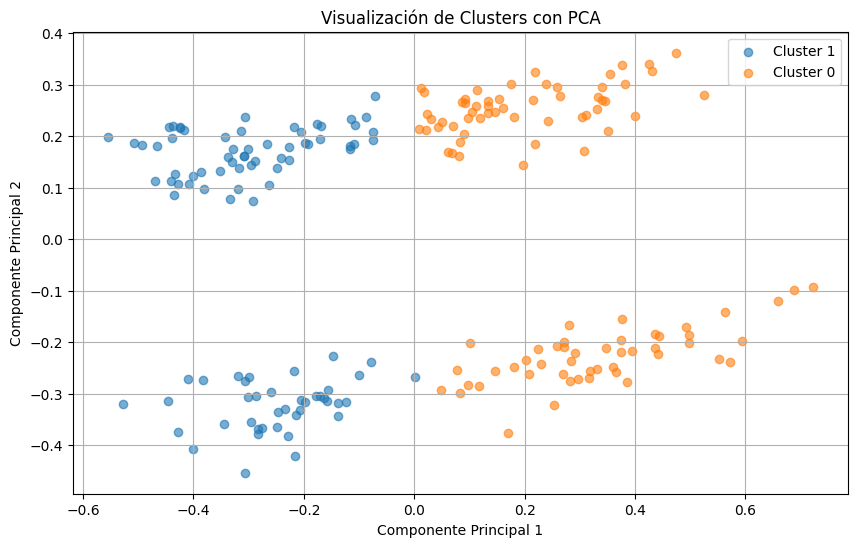

In [53]:
from sklearn.decomposition import PCA

df_scaled_cleaned['Cluster'] = labels
# Reducir dimensiones a 2D usando PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled_cleaned.drop(columns=["Cluster"]))

# Convertir a DataFrame y agregar etiquetas de cluster
df_pca = pd.DataFrame(df_pca, columns=["PC1", "PC2"])
df_pca["Cluster"] = df_scaled_cleaned["Cluster"]

# Graficar los clusters
plt.figure(figsize=(10, 6))
for cluster in df_pca["Cluster"].unique():
    subset = df_pca[df_pca["Cluster"] == cluster]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {cluster}", alpha=0.6)

plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualización de Clusters con PCA")
plt.legend()
plt.grid()
plt.show()